# Task 3: Model Design
 
**Objective:** Architect a neural network suitable for the accident severity classification task. Justify design choices and visualize the architecture.

In [1]:
import pandas as pd
import tensorflow as tf
from pathlib import Path
import os
import sys

# Setup Paths
PROJECT_ROOT = Path(os.getcwd()).parent if os.getcwd().endswith('notebooks') else Path(os.getcwd())
sys.path.append(str(PROJECT_ROOT))
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"

from src.models.model_arch import build_model

# Check for Graphviz (Required for visualization)
try:
    import pydot
    import graphviz
    print("Graphviz libraries detected.")
except ImportError:
    print("Graphviz/pydot not installed. Visualization might fail.")


2026-01-05 05:46:12.915835: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-05 05:46:13.556582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-05 05:46:16.016048: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/alazar/dev/crash-learner/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Graphviz libraries detected.


## 1. Load Data Metadata
We don't need the full dataset yet, just the input shapes and class counts to define the architecture.

In [2]:
# %%
# Load just the first row to infer shape
X_train_sample = pd.read_parquet(PROCESSED_DIR / "X_train.parquet").iloc[:5]
y_train_sample = pd.read_parquet(PROCESSED_DIR / "y_train.parquet").iloc[:5]

INPUT_DIM = X_train_sample.shape[1]
NUM_CLASSES = len(pd.read_parquet(PROCESSED_DIR / "y_train.parquet")['target'].unique())

print(f"Input Features: {INPUT_DIM}")
print(f"Output Classes: {NUM_CLASSES}")


Input Features: 168
Output Classes: 4


## 2. Model Architecture Design
 
### Design Rationale
 
 1.  **Input Layer**: Matches the number of features after One-Hot Encoding (~170 features).
 2.  **Hidden Layers**:
     *   **Structure**: Two dense layers (128 units $\to$ 64 units). This "funnel" shape compresses information to higher-level abstractions.
     *   **Activation**: **ReLU** (Rectified Linear Unit) is chosen to introduce non-linearity and prevent the vanishing gradient problem.
     *   **Batch Normalization**: Added to stabilize learning and accelerate convergence by normalizing layer inputs.
 3.  **Regularization (Overfitting Mitigation)**:
     *   **Dropout (0.3)**: Randomly disables 30% of neurons during training to prevent the model from relying on specific features (crucial for our noisy/imbalanced dataset).
     *   **L2 Regularization**: Penalizes large weights to keep the model simple.
 4.  **Output Layer**:
     *   **Neurons**: 4 (corresponding to Fatal, Minor, PDO, Serious).
     *   **Activation**: **Softmax**. This converts raw logits into probabilities that sum to 1.
 5.  **Loss Function**:
     *   **Sparse Categorical Cross-Entropy**: Appropriate because our targets are integers (0, 1, 2, 3) and classes are mutually exclusive.


In [3]:
# Build the model
model = build_model(input_dim=INPUT_DIM, num_classes=NUM_CLASSES)

# Display Summary
model.summary()

2026-01-05 05:47:35.712939: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "Crash_Severity_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 168)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_1 (Dense)          │ (None, 128)            │        21,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batch_Norm_1                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ReLU_1 (Activation)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Batch_Norm_2                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ReLU_2 (Activation)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,916 (120.77 KB)

 Trainable params: 30,532 (119.27 KB)

 Non-trainable params: 384 (1.50 KB)

## 3. Architecture Visualization

Using `graphviz` to generate a structural diagram of the network.


✅ Model diagram saved to /home/alazar/dev/crash-learner/reports/figures/model_architecture.png


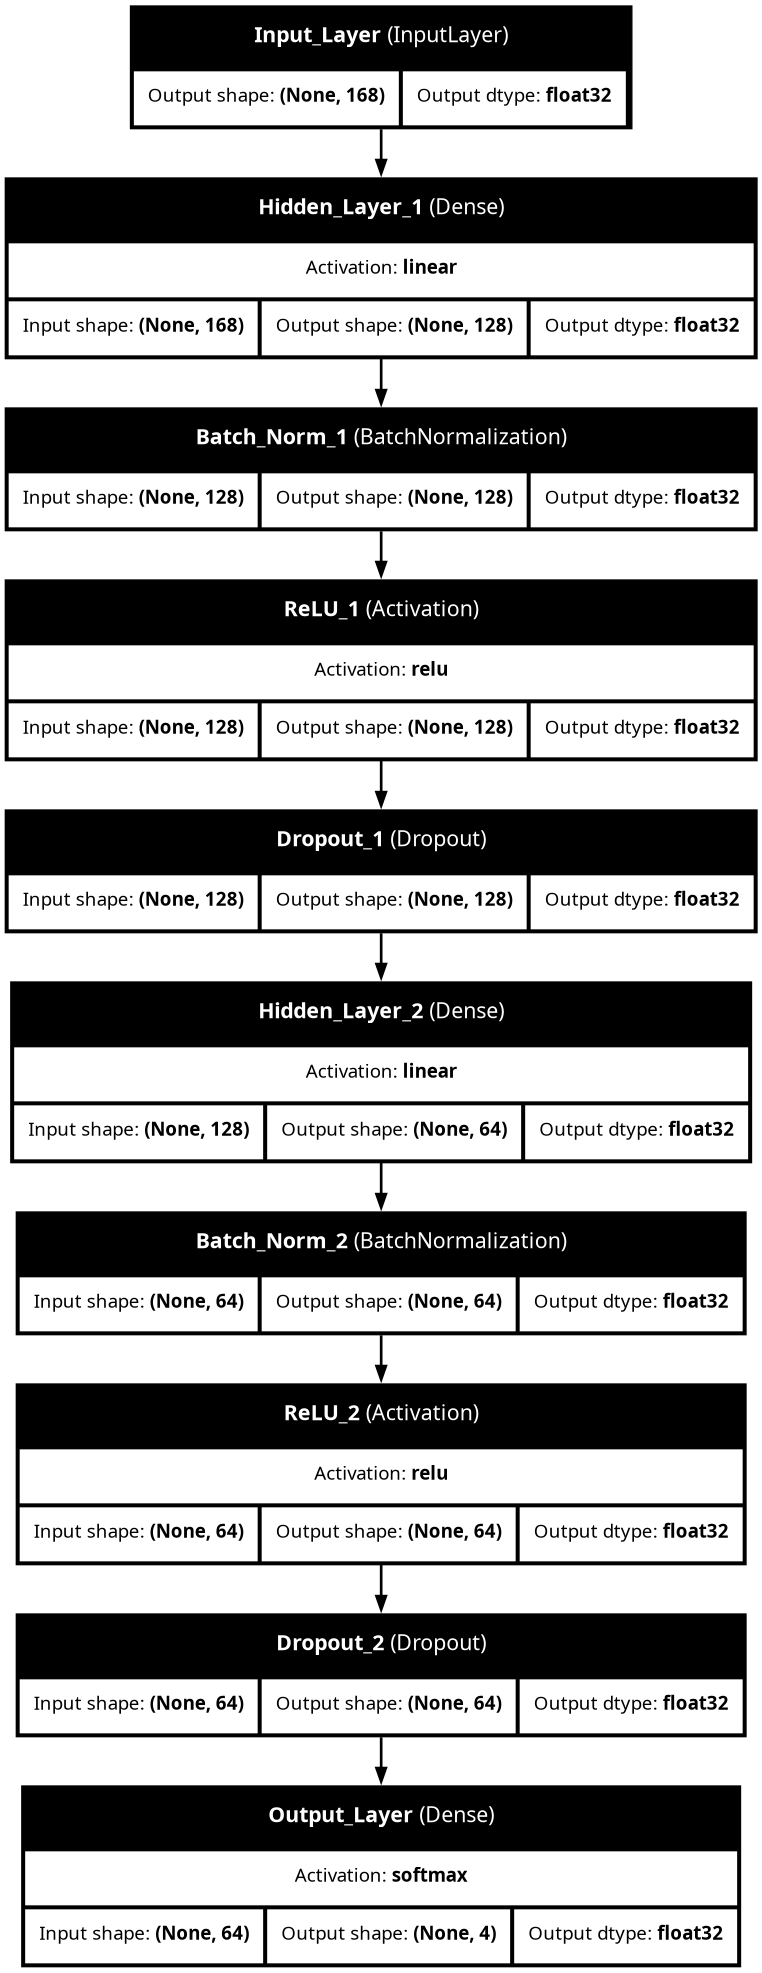

In [4]:
plot_path = FIGURES_DIR / "model_architecture.png"

tf.keras.utils.plot_model(
    model,
    to_file=plot_path,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB", # Top-to-Bottom
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

print(f"✅ Model diagram saved to {plot_path}")

# Display the image in notebook
from IPython.display import Image
Image(filename=plot_path) 


## 4. Complexity Analysis (Updated)

Based on the model summary:

1.  **Input Dimensionality:** The model received **168 input features**. This dimension is larger than the raw dataframe column count because categorical variables (like Woreda, Road Type, etc.) were One-Hot Encoded, creating binary columns for the unique categories.
2.  **Parameter Count:** The model has exactly **30,916 parameters**.
    *   **Input $\to$ Hidden 1:** $168 \text{ (features)} \times 128 \text{ (neurons)} + 128 \text{ (biases)} = 21,632$ parameters.
    *   **Batch Normalization 1:** $128 \times 4 = 512$ parameters.
    *   **Hidden 1 $\to$ Hidden 2:** $128 \times 64 + 64 = 8,256$ parameters.
    *   **Batch Normalization 2:** $64 \times 4 = 256$ parameters.
    *   **Hidden 2 $\to$ Output:** $64 \times 4 \text{ (classes)} + 4 = 260$ parameters.

**Conclusion:** 
With ~31k parameters, the model is lightweight and computationally efficient. Crucially, the **Output Layer has 4 units**, corresponding to the 4 expected severity classes. This confirms that the target variable cleaning was successful and the model is not attempting to predict a "NaN" or "Unknown" class.